# パッケージ


In [1]:
import pandas as pd
import datetime
import re
import os, time
from tqdm import tqdm
import category_encoders as ce
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.decomposition import PCA
from abc import ABC, abstractmethod
import torch.nn.functional as F
from torch.utils.data.dataset import Subset
import random
import matplotlib.pyplot as plt
from bitnet import BitLinear

# クラス


## データセットクラス


In [2]:
class CustomDataSet(Dataset):

    def __init__(self, data, is_file=False):
        """
        Args:
            file_paths (list of str): 学習用データファイルのパスのリスト
        """
        self.data = data
        self.file = is_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.file:
            file_path = self.data[idx]
            with open(file_path, "rb") as f:
                data = pickle.load(f)
            inputs = torch.cat([data["race"], data["horse"], data["results"]])
            labels = data["label"]
            return inputs, labels
        else:
            data_set = self.data[idx]
            return data_set["data"], data_set["label"]

## NN モデル


In [3]:
class BitNetClassifier(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        layers=[128, 128],
        dropout_rate=0.2,
        activation="mish",
        output_activation="sig",  # 変数名を変更して明確にします
    ):
        # モデル保存のために保存しておくパラメータ
        self.input_size = input_size
        self.output_size = output_size
        self.layer_size = layers
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.output_activation = output_activation

        super(BitNetClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleDict(
            {
                "relu": nn.ReLU(),
                "leaky_relu": nn.LeakyReLU(),
                "mish": nn.Mish(),
            }
        )
        self.dropout = nn.Dropout(dropout_rate)
        # 入力層
        prev_size = self.input_size
        for layer_size in self.layer_size:
            self.layers.append(BitLinear(prev_size, layer_size))
            prev_size = layer_size
        # 出力層
        self.out = BitLinear(prev_size, self.output_size)
        if output_activation == "sig":
            self.activation_out = nn.Sigmoid()
        elif output_activation == "softmax":
            self.activation_out = nn.Softmax(dim=1)  # 正しい構文
        else:
            raise ValueError("Unsupported output activation. Use 'sig' or 'softmax'.")
        self.activation = activation

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.activations[self.activation](x)
            x = self.dropout(x)
        x = self.out(x)
        x = self.activation_out(x)
        return x

In [4]:
class NNClassifier(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        layers=[128, 128],
        dropout_rate=0.2,
        activation="mish",
        output_activation="sig",  # 変数名を変更して明確にします
    ):
        # モデル保存のために保存しておくパラメータ
        self.input_size = input_size
        self.output_size = output_size
        self.layer_size = layers
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.output_activation = output_activation

        super(NNClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleDict(
            {
                "relu": nn.ReLU(),
                "leaky_relu": nn.LeakyReLU(),
                "mish": nn.Mish(),
            }
        )
        self.dropout = nn.Dropout(dropout_rate)
        # 入力層
        prev_size = self.input_size
        for layer_size in self.layer_size:
            self.layers.append(nn.Linear(prev_size, layer_size))
            prev_size = layer_size
        # 出力層
        self.out = nn.Linear(prev_size, self.output_size)
        if output_activation == "sig":
            self.activation_out = nn.Sigmoid()
        elif output_activation == "softmax":
            self.activation_out = nn.Softmax(dim=1)  # 正しい構文
        else:
            raise ValueError("Unsupported output activation. Use 'sig' or 'softmax'.")
        self.activation = activation

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.activations[self.activation](x)
            x = self.dropout(x)
        x = self.out(x)
        x = self.activation_out(x)
        return x

# メソッド


## データローダーを作成する関数


In [5]:
def make_data_loader(dataset, ratio: [int, int, int], batch=32, ensemble=0):
    """データローダーを作る関数

    Args:
        dataset (_type_): 使用するデータセット
        ratio (int, int, int]): 訓練、検証、テストデータの比率
        batch (int, optional): バッチサイズ。デフォルトは32
        ensemble (int, optional): 訓練データの分割数（アンサンブル学習用）。デフォルトは0(分けない)

    Returns:
        _type_: _description_
    """
    dataset_size = len(dataset)
    train_rate = ratio[0] / sum(ratio)
    val_rate = ratio[1] / sum(ratio)
    # 分割比率を設定 (例: 訓練:検証:テスト = 70%:15%:15%)
    train_size = int(dataset_size * train_rate)
    val_size = int(dataset_size * val_rate)
    test_size = dataset_size - train_size - val_size  # 残りをテストとする

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    if ensemble:
        sub_train_sizes = [
            int(train_size / ensemble) for _ in range(ensemble)
        ]  # 最初の4つのサイズ
        sub_train_sizes.append(
            train_size - sum(sub_train_sizes)
        )  # 最後のサブセットのサイズ
        # 分割された訓練データセットのインデックスを生成
        indices = torch.randperm(train_size).tolist()
        train_dataset = [
            Subset(
                train_dataset,
                indices[sum(sub_train_sizes[:i]) : sum(sub_train_sizes[: i + 1])],
            )
            for i in range(ensemble)
        ]

        # 各サブセットに対応するDataLoaderを作成
        train_loader = [
            DataLoader(dataset, batch_size=batch, shuffle=True, pin_memory=True)
            for dataset in train_dataset
        ]
    else:
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch,
            shuffle=False,
            pin_memory=True,
        )
    # 検証、確認用のDataLoaderを作成
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch,
        shuffle=False,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch,
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader, test_loader

# 複勝基準モデル


## 学習


### 学習データの用意


In [9]:
# ファイルで学習させるとき
results_path = "../Processed-Data/Race-Results/"
dir_list_raw = os.listdir(results_path)
dir_list = list(map(lambda x: f"../Processed-Data/Race-Results/{x}", dir_list_raw))
dataset = CustomDataSet(dir_list, is_file=True)

dataset_size = len(dataset)
# 分割比率を設定 (例: 訓練:検証:テスト = 70%:15%:15%)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size  # 残りをテストセットとする

print(f"train:{train_size}")
print(f"val:{val_size}")
print(f"test:{test_size}")

# データセットをランダムに分割
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

batch = 16
# DataLoaderを作成
train_loader = DataLoader(
    train_dataset,
    batch_size=batch,
    shuffle=True,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch,
    shuffle=False,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch,
    shuffle=False,
    pin_memory=True,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train:21765
val:4663
test:4665
cuda


### 各ラベルの分布を調べる


In [ ]:
def get_all_files_in_directory(path):
    """
    指定したパスの配下にあるすべてのファイル（子孫ファイルも含む）のリストを返します。

    :param path: ファイルを検索するディレクトリのパス
    :return: ファイルのパスのリスト
    """
    files_list = []
    for root, dirs, files in os.walk(path):
        for file_name in files:
            files_list.append(f"{root}/{file_name}")
    return files_list


zero_distribution = torch.zeros(18)
one_distribution = torch.zeros(18)
dir_list = get_all_files_in_directory("../Processed-Data/Race-Results")
for i in tqdm(dir_list):
    with open(i, "rb") as f:
        data = pickle.load(f)
    labels = data["label"]
    # ラベルが1の位置をカウント
    one_distribution += labels
    # ラベルが0の位置をカウント（全ての要素から1のカウントを引く）
    zero_distribution += 1 - labels

# 0が1に対してどれくらい多いかの割合を計算
zero_to_one_ratio = zero_distribution / one_distribution
one_to_zero_ratio = one_distribution / zero_distribution

print("0が1に対してどれくらい多いかの割合:\n", zero_to_one_ratio)
print("その逆\n", one_to_zero_ratio)

In [13]:
# テンソルの平均
weight_tensor_one = torch.tensor(
    [
        4.0467,
        3.8973,
        4.0508,
        3.7718,
        4.0142,
        3.8689,
        4.0264,
        4.0231,
        4.4075,
        4.6175,
        5.3236,
        5.6824,
        7.1395,
        8.0703,
        9.9560,
        12.4485,
        85.8520,
        96.1656,
    ],
    dtype=torch.float,
)
torch.mean(weight_tensor_one)

tensor(15.0757)

In [14]:
torch.ones_like(weight_tensor_one) * 15

tensor([15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
        15., 15., 15., 15.])

### モデルの用意


In [11]:
class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()
        self.weight_tensor_one = torch.tensor(
            [
                4.0467,
                3.8973,
                4.0508,
                3.7718,
                4.0142,
                3.8689,
                4.0264,
                4.0231,
                4.4075,
                4.6175,
                5.3236,
                5.6824,
                7.1395,
                8.0703,
                9.9560,
                12.4485,
                85.8520,
                96.1656,
            ],
            dtype=torch.float,
        ).to("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, logits, targets):
        # ラベルが1の要素に対してweight_tensor_oneの重みを適用し、
        # ラベルが0の要素に対しては1の重みを適用
        weights = torch.where(
            targets == 1, self.weight_tensor_one, torch.ones_like(targets)
        )
        weights = weights.to(targets.device)  # weightsをtargetsと同じデバイスに移動
        # 重み付きバイナリクロスエントロピー損失の計算
        loss = F.binary_cross_entropy_with_logits(logits, targets, weight=weights)
        return loss


model = NNClassifier(1534, 18).to(device)
criterion = WeightedBCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)

In [12]:
def check_accuracy_topk(loader, model, k=3):
    num_correct_1 = 0
    num_samples_1 = 0
    num_correct_0 = 0
    num_samples_0 = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            # 上位k個の予測を1に、それ以外を0にする
            topk_predictions = torch.zeros_like(scores, device=device)
            topk_vals, topk_indices = scores.topk(k, dim=1)
            # 上位k個の位置に1を設定
            topk_predictions.scatter_(1, topk_indices, 1)
            # 1の場合
            correct_predictions_1 = topk_predictions.bool() & y.bool()
            num_correct_1 += correct_predictions_1.type(torch.float).sum().item()
            num_samples_1 += y.sum().item()
            # 0の場合
            correct_predictions_0 = (~topk_predictions.bool()) & (~y.bool())
            num_correct_0 += correct_predictions_0.type(torch.float).sum().item()
            num_samples_0 += (1 - y).sum().item()
        # 正解率の計算
        accuracy_1 = (num_correct_1 / num_samples_1 * 100) if num_samples_1 > 0 else 0
        accuracy_0 = (num_correct_0 / num_samples_0 * 100) if num_samples_0 > 0 else 0
    model.train()
    return f"Accuracy for label 1: {accuracy_1:.2f}%\nAccuracy for label 0: {accuracy_0:.2f}%"


num_epochs = 500


for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        x = data.to(device)
        y = targets.to(device)
        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}]  Loss{loss}\n{check_accuracy_topk(val_loader, model)}"
        )

KeyboardInterrupt: 

### 評価


In [11]:
def check_accuracy_topk(loader, model, k=3):
    num_correct_1 = 0
    num_samples_1 = 0
    num_correct_0 = 0
    num_samples_0 = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            # 上位k個の予測を1に、それ以外を0にする
            topk_predictions = torch.zeros_like(scores, device=device)
            topk_vals, topk_indices = scores.topk(k, dim=1)
            # 上位k個の位置に1を設定
            topk_predictions.scatter_(1, topk_indices, 1)
            # 1の場合
            correct_predictions_1 = topk_predictions.bool() & y.bool()
            num_correct_1 += correct_predictions_1.type(torch.float).sum().item()
            num_samples_1 += y.sum().item()
            # 0の場合
            correct_predictions_0 = (~topk_predictions.bool()) & (~y.bool())
            num_correct_0 += correct_predictions_0.type(torch.float).sum().item()
            num_samples_0 += (1 - y).sum().item()
        # 正解率の計算
        accuracy_1 = (num_correct_1 / num_samples_1 * 100) if num_samples_1 > 0 else 0
        accuracy_0 = (num_correct_0 / num_samples_0 * 100) if num_samples_0 > 0 else 0
    model.train()
    return f"Accuracy for label 1: {accuracy_1:.2f}%\nAccuracy for label 0: {accuracy_0:.2f}%"


print(check_accuracy_topk(test_loader, model, 3))

'Accuracy for label 1: 35.36%\nAccuracy for label 0: 86.65%'

### モデル保存(状態のみ)


In [10]:
torch.save(model.state_dict(), "../models/nn_classifier_1.pth")

# 複勝・単勝ハイブリッドモデル


## 学習データの用意


In [6]:
# 複勝用のデータローダー作成
results_path = "../Processed-Data/Race-Results/"
dir_list_raw = os.listdir(results_path)
dir_list = list(map(lambda x: f"../Processed-Data/Race-Results/{x}", dir_list_raw))
dataset_top = CustomDataSet(dir_list, is_file=True)

train_loader_multi, val_loader_multi, test_loader_multi = make_data_loader(
    dataset_top, [70, 15, 15], 16
)

In [7]:
results_path = "../Processed-Data/Race-Results/"
dir_list_raw = os.listdir(results_path)
dir_list = list(
    map(lambda x: f"../Processed-Data/Race-Results-single/{x}", dir_list_raw)
)
dataset_top = CustomDataSet(dir_list, is_file=True)

train_loader_single, val_loader_single, test_loader_single = make_data_loader(
    dataset_top, [70, 15, 15], 16
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 各ラベルの分布を調べる


In [ ]:
def get_all_files_in_directory(path):
    """
    指定したパスの配下にあるすべてのファイル（子孫ファイルも含む）のリストを返します。

    :param path: ファイルを検索するディレクトリのパス
    :return: ファイルのパスのリスト
    """
    files_list = []
    for root, dirs, files in os.walk(path):
        for file_name in files:
            files_list.append(f"{root}/{file_name}")
    return files_list


zero_distribution = torch.zeros(18)
one_distribution = torch.zeros(18)
dir_list = get_all_files_in_directory("../Processed-Data/Race-Results-single")
for i in tqdm(dir_list):
    with open(i, "rb") as f:
        data = pickle.load(f)
    labels = data["label"]
    # ラベルが1の位置をカウント
    one_distribution += labels
    # ラベルが0の位置をカウント（全ての要素から1のカウントを引く）
    zero_distribution += 1 - labels

# 0が1に対してどれくらい多いかの割合を計算
zero_to_one_ratio = zero_distribution / one_distribution
one_to_zero_ratio = one_distribution / zero_distribution

print("0が1に対してどれくらい多いかの割合:\n", zero_to_one_ratio)
print("その逆\n", one_to_zero_ratio)

## 独自の誤差関数を定義


In [8]:
class WeightedBCELossMulti(nn.Module):
    def __init__(self):
        super(WeightedBCELossMulti, self).__init__()
        self.weight_tensor_one = torch.tensor(
            [
                4.0467,
                3.8973,
                4.0508,
                3.7718,
                4.0142,
                3.8689,
                4.0264,
                4.0231,
                4.4075,
                4.6175,
                5.3236,
                5.6824,
                7.1395,
                8.0703,
                9.9560,
                12.4485,
                85.8520,
                96.1656,
            ],
            dtype=torch.float,
        ).to("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, logits, targets):
        # ラベルが1の要素に対してweight_tensor_oneの重みを適用し、
        # ラベルが0の要素に対しては1の重みを適用
        weights = torch.where(
            targets == 1, self.weight_tensor_one, torch.ones_like(targets)
        )
        weights = weights.to(targets.device)  # weightsをtargetsと同じデバイスに移動
        # 重み付きバイナリクロスエントロピー損失の計算
        loss = F.binary_cross_entropy_with_logits(logits, targets, weight=weights)
        return loss


class WeightedBCELossSingle(nn.Module):
    def __init__(self):
        super(WeightedBCELossSingle, self).__init__()
        self.weight_tensor_one = torch.tensor(
            [
                14.4231,
                13.7151,
                14.2716,
                13.3220,
                14.3394,
                13.4956,
                13.9918,
                14.0644,
                15.4426,
                15.6629,
                17.5519,
                18.9955,
                23.4058,
                25.5072,
                31.7985,
                38.7101,
                271.7456,
                264.7521,
            ],
            dtype=torch.float,
        ).to("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, logits, targets):
        # ラベルが1の要素に対してweight_tensor_oneの重みを適用し、
        # ラベルが0の要素に対しては1の重みを適用
        weights = torch.where(
            targets == 1, self.weight_tensor_one, torch.ones_like(targets)
        )
        weights = weights.to(targets.device)  # weightsをtargetsと同じデバイスに移動
        # 重み付きバイナリクロスエントロピー損失の計算
        loss = F.binary_cross_entropy_with_logits(logits, targets, weight=weights)
        return loss

## 学習


### 検証メソッド


In [9]:
def check_accuracy_topk(loader, model, k=3):
    num_correct_1 = 0
    num_samples_1 = 0
    num_correct_0 = 0
    num_samples_0 = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            # 上位k個の予測を1に、それ以外を0にする
            topk_predictions = torch.zeros_like(scores, device=device)
            topk_vals, topk_indices = scores.topk(k, dim=1)
            # 上位k個の位置に1を設定
            topk_predictions.scatter_(1, topk_indices, 1)
            # 1の場合
            correct_predictions_1 = topk_predictions.bool() & y.bool()
            num_correct_1 += correct_predictions_1.type(torch.float).sum().item()
            num_samples_1 += y.sum().item()
            # 0の場合
            correct_predictions_0 = (~topk_predictions.bool()) & (~y.bool())
            num_correct_0 += correct_predictions_0.type(torch.float).sum().item()
            num_samples_0 += (1 - y).sum().item()
        # 正解率の計算
        accuracy_1 = (num_correct_1 / num_samples_1 * 100) if num_samples_1 > 0 else 0
        accuracy_0 = (num_correct_0 / num_samples_0 * 100) if num_samples_0 > 0 else 0
    model.train()
    # return f"Accuracy for label 1: {accuracy_1:.2f}%\nAccuracy for label 0: {accuracy_0:.2f}%"
    return accuracy_1, accuracy_0

### モデル定義


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# 複勝
model_multi = NNClassifier(1534, 18, [128, 128]).to(device)
# model_multi = BitNetClassifier(1534, 18, [128, 128]).to(device)

In [11]:
# 単勝
model_single = NNClassifier(1534, 18, [128, 128]).to(device)

### 各モデルのパラメータ設定


In [23]:
epochs = 50

lr = 1e-6
optimizer_multi = torch.optim.AdamW(model_multi.parameters(), lr=lr)
optimizer_single = torch.optim.AdamW(model_single.parameters(), lr=lr)

criterion_multi = WeightedBCELossMulti().to(device)
criterion_single = WeightedBCELossSingle().to(device)

show_num = 10

### 複勝モデル学習


Epoch 10: Loss = 1.23152, Accuracy 1 = 15.44%, Accuracy 0 = 83.12%
Epoch 20: Loss = 1.23128, Accuracy 1 = 18.66%, Accuracy 0 = 83.69%
Epoch 30: Loss = 1.23102, Accuracy 1 = 19.28%, Accuracy 0 = 83.79%
Epoch 40: Loss = 1.23081, Accuracy 1 = 20.76%, Accuracy 0 = 84.06%
Epoch 50: Loss = 1.23061, Accuracy 1 = 19.01%, Accuracy 0 = 83.75%


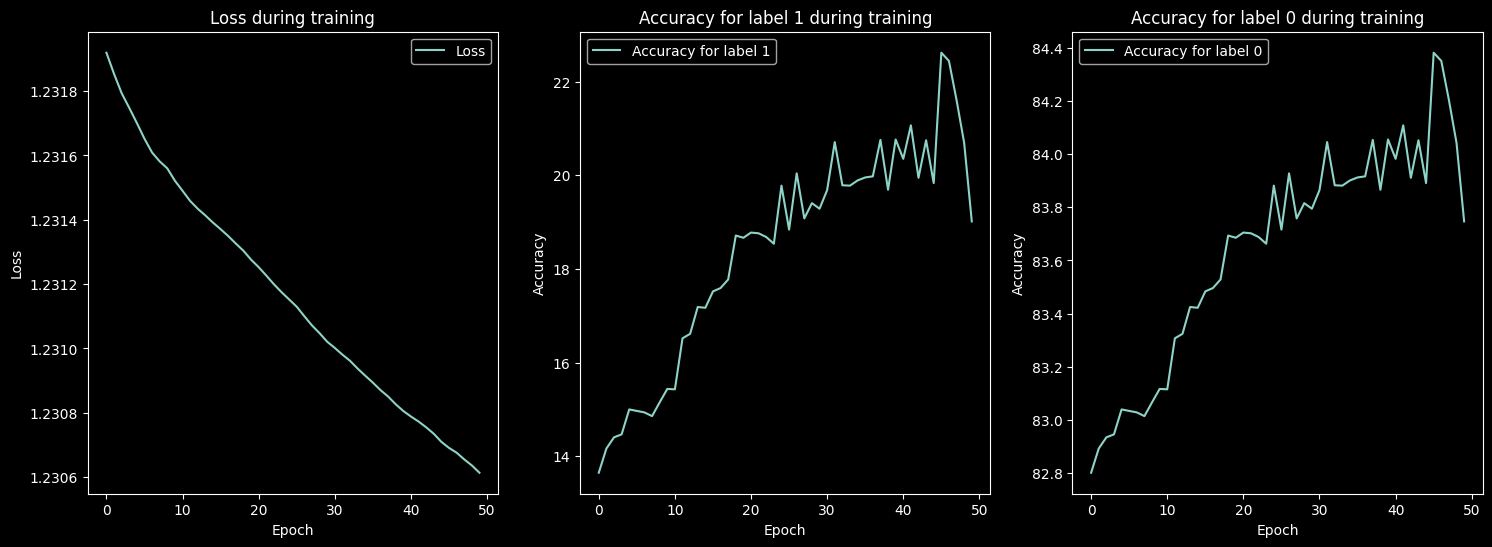

In [24]:
# 誤差、ラベル1の正答率、ラベル0の正答率を記録するリストを初期化
losses = []
accuracies_1 = []
accuracies_0 = []
# 前回との正答率の差分
diff_acc1 = 0
# 前回の正答率
acc1_tmp = -1

for epoch in range(epochs):
    epoch_losses = []
    for batch_idx, (data, targets) in enumerate(train_loader_multi):
        x = data.to(device)
        y = targets.to(device)
        scores = model_multi(x)
        loss = criterion_multi(scores, y)
        optimizer_multi.zero_grad()
        loss.backward()
        optimizer_multi.step()
        epoch_losses.append(loss.item())
    # エポックの平均誤差を記録
    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(epoch_loss)

    # 正答率を計算して記録
    accuracy_1, accuracy_0 = check_accuracy_topk(val_loader_multi, model_multi, 3)
    accuracies_1.append(accuracy_1)
    accuracies_0.append(accuracy_0)

    if (epoch + 1) % show_num == 0:
        print(
            f"Epoch {epoch + 1:.4g}: Loss = {epoch_loss:.5f}, Accuracy 1 = {accuracy_1:.2f}%, Accuracy 0 = {accuracy_0:.2f}%"
        )

    if (epoch + 1) % 50 == 0:  # 50エポックごとに確認する
        # ２回連続で正答率が下がったら学習を強制終了する
        if diff_acc1 < 0 and (accuracy_1 - acc1_tmp) < 0:
            print(f"epoch{epoch}, diff{diff_acc1}, {accuracy_1 - acc1_tmp}")
            print("Force close because the accuracy has decreased twice in a row")
            break
        # 現在の正答率とその変化量を更新
        diff_acc1 = accuracy_1 - acc1_tmp if epoch > 0 else 0
        acc1_tmp = accuracy_1


# モデルのパラメータ
model_params = {
    "input_size": model_multi.input_size,
    "output_size": model_multi.output_size,
    "layers": model_multi.layer_size,  # layers_sizesは各隠れ層のノード数をリストで保持する属性です
    "dropout_rate": model_multi.dropout_rate,  # dropout_rateはドロップアウト率を保持する属性です
    "activation": model_multi.activation,  # activation_typeは活性化関数の種類を保持する属性です
    "output_activation": model_multi.output_activation,  # output_activation_typeは出力層の活性化関数の種類を保持する属性です
}

# モデルの状態とパラメータを辞書に格納
model_info = {"state_dict": model_multi.state_dict(), "params": model_params}

# モデル情報をファイルに保存
torch.save(model_info, f"../models/nn/multi-test.pth")

# 学習が完了した後、誤差と正答率の推移をプロット
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(losses, label="Loss")
plt.title("Loss during training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(accuracies_1, label="Accuracy for label 1")
plt.title("Accuracy for label 1 during training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(accuracies_0, label="Accuracy for label 0")
plt.title("Accuracy for label 0 during training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 単勝モデル学習


Epoch 100: Loss = 1.26316, Accuracy 1 = 22.72%, Accuracy 0 = 83.65%
Epoch 200: Loss = 1.25500, Accuracy 1 = 23.51%, Accuracy 0 = 83.69%
Epoch 300: Loss = 1.24439, Accuracy 1 = 26.08%, Accuracy 0 = 83.83%
Epoch 400: Loss = 1.23327, Accuracy 1 = 27.90%, Accuracy 0 = 83.92%
Epoch 500: Loss = 1.22171, Accuracy 1 = 30.85%, Accuracy 0 = 84.08%
Epoch 600: Loss = 1.21063, Accuracy 1 = 33.07%, Accuracy 0 = 84.20%
Epoch 700: Loss = 1.19803, Accuracy 1 = 35.10%, Accuracy 0 = 84.30%
Epoch 800: Loss = 1.18691, Accuracy 1 = 36.17%, Accuracy 0 = 84.36%
Epoch 900: Loss = 1.17546, Accuracy 1 = 37.34%, Accuracy 0 = 84.42%
Epoch 1000: Loss = 1.16505, Accuracy 1 = 38.22%, Accuracy 0 = 84.47%
Epoch 1100: Loss = 1.15563, Accuracy 1 = 39.06%, Accuracy 0 = 84.51%
Epoch 1200: Loss = 1.14727, Accuracy 1 = 39.25%, Accuracy 0 = 84.52%
Epoch 1300: Loss = 1.13925, Accuracy 1 = 39.60%, Accuracy 0 = 84.54%
Epoch 1400: Loss = 1.13162, Accuracy 1 = 39.91%, Accuracy 0 = 84.56%
Epoch 1500: Loss = 1.12482, Accuracy 1 = 40

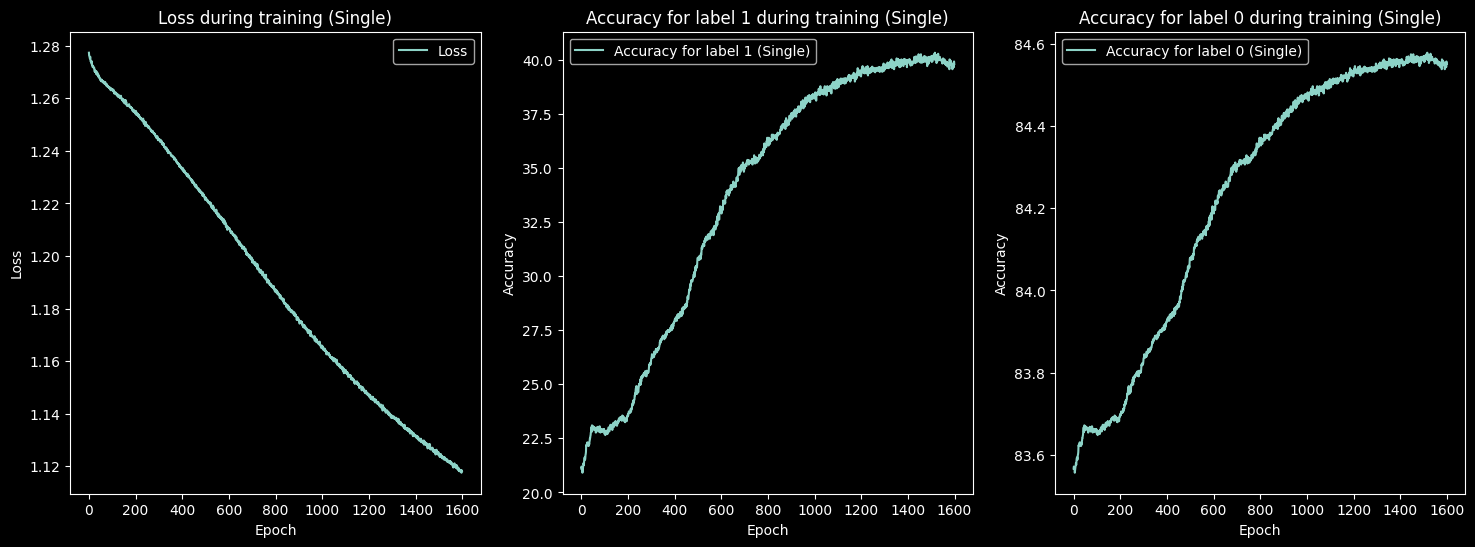

In [16]:
# 誤差、ラベル1の正答率、ラベル0の正答率を記録するリストを初期化
losses_single = []
accuracies_1_single = []
accuracies_0_single = []
# 前回との正答率の差分
diff_acc1 = 0
# 前回の正答率
acc1_tmp = -1

for epoch in range(epochs):
    epoch_losses_single = []
    for batch_idx, (data, targets) in enumerate(train_loader_single):
        x = data.to(device)
        y = targets.to(device)
        scores = model_single(x)
        loss = criterion_single(scores, y)
        optimizer_single.zero_grad()
        loss.backward()
        optimizer_single.step()
        epoch_losses_single.append(loss.item())
    # エポックの平均誤差を記録
    epoch_loss_single = sum(epoch_losses_single) / len(epoch_losses_single)
    losses_single.append(epoch_loss_single)

    # 正答率を計算して記録
    accuracy_1_single, accuracy_0_single = check_accuracy_topk(
        val_loader_single, model_single, 3
    )
    accuracies_1_single.append(accuracy_1_single)
    accuracies_0_single.append(accuracy_0_single)

    if (epoch + 1) % show_num == 0:
        print(
            f"Epoch {epoch + 1:.4g}: Loss = {epoch_loss_single:.5f}, Accuracy 1 = {accuracy_1_single:.2f}%, Accuracy 0 = {accuracy_0_single:.2f}%"
        )

    if (epoch + 1) % 50 == 0:  # 50エポックごとに確認する
        # ２回連続で正答率が下がったら学習を強制終了する
        if diff_acc1 < 0 and (accuracy_1_single - acc1_tmp) < 0:
            print(f"epoch{epoch}, diff{diff_acc1}, {accuracy_1_single - acc1_tmp}")
            print("Force close because the accuracy has decreased twice in a row")
            break
        # 現在の正答率とその変化量を更新
        diff_acc1 = accuracy_1_single - acc1_tmp if epoch > 0 else 0
        acc1_tmp = accuracy_1_single


# モデルのパラメータ
model_params = {
    "input_size": model_multi.input_size,
    "output_size": model_multi.output_size,
    "layers": model_multi.layer_size,  # layers_sizesは各隠れ層のノード数をリストで保持する属性です
    "dropout_rate": model_multi.dropout_rate,  # dropout_rateはドロップアウト率を保持する属性です
    "activation": model_multi.activation,  # activation_typeは活性化関数の種類を保持する属性です
    "output_activation": model_multi.output_activation,  # output_activation_typeは出力層の活性化関数の種類を保持する属性です
}

# モデルの状態とパラメータを辞書に格納
model_info = {"state_dict": model_single.state_dict(), "params": model_params}

# モデル情報をファイルに保存
torch.save(model_info, f"../models/nn/single-test.pth")

# 学習が完了した後、誤差と正答率の推移をプロット
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(losses_single, label="Loss")
plt.title("Loss during training (Single)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(accuracies_1_single, label="Accuracy for label 1 (Single)")
plt.title("Accuracy for label 1 during training (Single)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(accuracies_0_single, label="Accuracy for label 0 (Single)")
plt.title("Accuracy for label 0 during training (Single)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### テスト


In [12]:
def check_accuracy_topk_test(loaders, model_multi, model_single, k=3):
    num_correct_1 = 0
    num_samples_1 = 0
    num_correct_0 = 0
    num_samples_0 = 0
    model_multi.eval()
    model_single.eval()
    with torch.no_grad():
        for x, y in loaders:
            x = x.to(device)
            y = y.to(device)
            scores_multi = model_multi(x)
            scores_single = model_single(x)
            # 予測の平均を計算
            avg_predictions = torch.mean(
                torch.stack([scores_multi, scores_single]), dim=0
            )
            # 上位k個の予測を1に、それ以外を0にする
            topk_predictions = torch.zeros_like(avg_predictions, device=device)
            topk_vals, topk_indices = avg_predictions.topk(k, dim=1)
            topk_predictions.scatter_(1, topk_indices, 1)
            # 1の場合
            correct_predictions_1 = topk_predictions.bool() & y.bool()
            num_correct_1 += correct_predictions_1.type(torch.float).sum().item()
            num_samples_1 += y.sum().item()
            # 0の場合
            correct_predictions_0 = (~topk_predictions.bool()) & (~y.bool())
            num_correct_0 += correct_predictions_0.type(torch.float).sum().item()
            num_samples_0 += (1 - y).sum().item()

    # 正解率の計算
    accuracy_1 = (num_correct_1 / num_samples_1 * 100) if num_samples_1 > 0 else 0
    accuracy_0 = (num_correct_0 / num_samples_0 * 100) if num_samples_0 > 0 else 0
    model_multi.train()
    model_single.train()

    return f"複合モデル - ラベル1の正答率: {accuracy_1:.2f}%, ラベル0の正答率: {accuracy_0:.2f}%"


def check_accuracy_topk_test_compare(loaders, model_multi, model_single, k=3):
    num_correct_1_multi = 0
    num_samples_1_multi = 0
    num_correct_0_multi = 0
    num_samples_0_multi = 0
    num_correct_1_single = 0
    num_samples_1_single = 0
    num_correct_0_single = 0
    num_samples_0_single = 0
    model_multi.eval()
    model_single.eval()

    with torch.no_grad():
        for x, y in loaders:
            x = x.to(device)
            y = y.to(device)
            scores_multi = model_multi(x)
            scores_single = model_single(x)
            # 複勝モデルの正答率計算
            topk_predictions_multi = torch.zeros_like(scores_multi, device=device)
            topk_vals_multi, topk_indices_multi = scores_multi.topk(k, dim=1)
            topk_predictions_multi.scatter_(1, topk_indices_multi, 1)
            correct_predictions_1_multi = topk_predictions_multi.bool() & y.bool()
            num_correct_1_multi += (
                correct_predictions_1_multi.type(torch.float).sum().item()
            )
            num_samples_1_multi += y.sum().item()
            correct_predictions_0_multi = (~topk_predictions_multi.bool()) & (~y.bool())
            num_correct_0_multi += (
                correct_predictions_0_multi.type(torch.float).sum().item()
            )
            num_samples_0_multi += (1 - y).sum().item()
            # 単勝モデルの正答率計算
            topk_predictions_single = torch.zeros_like(scores_single, device=device)
            topk_vals_single, topk_indices_single = scores_single.topk(k, dim=1)
            topk_predictions_single.scatter_(1, topk_indices_single, 1)
            correct_predictions_1_single = topk_predictions_single.bool() & y.bool()
            num_correct_1_single += (
                correct_predictions_1_single.type(torch.float).sum().item()
            )
            num_samples_1_single += y.sum().item()
            correct_predictions_0_single = (~topk_predictions_single.bool()) & (
                ~y.bool()
            )
            num_correct_0_single += (
                correct_predictions_0_single.type(torch.float).sum().item()
            )
            num_samples_0_single += (1 - y).sum().item()

    accuracy_1_multi = (
        (num_correct_1_multi / num_samples_1_multi * 100)
        if num_samples_1_multi > 0
        else 0
    )
    accuracy_0_multi = (
        (num_correct_0_multi / num_samples_0_multi * 100)
        if num_samples_0_multi > 0
        else 0
    )
    accuracy_1_single = (
        (num_correct_1_single / num_samples_1_single * 100)
        if num_samples_1_single > 0
        else 0
    )
    accuracy_0_single = (
        (num_correct_0_single / num_samples_0_single * 100)
        if num_samples_0_single > 0
        else 0
    )
    model_multi.train()
    model_single.train()

    return (
        f"複勝モデル - ラベル1の正答率: {accuracy_1_multi:.2f}%, ラベル0の正答率: {accuracy_0_multi:.2f}%\n"
        f"単勝モデル - ラベル1の正答率: {accuracy_1_single:.2f}%, ラベル0の正答率: {accuracy_0_single:.2f}%"
    )

In [16]:
def model_load(path: str):
    # モデル情報をファイルから読み込む
    model_info = torch.load(path)

    # 読み込んだパラメータを使用してモデルインスタンスを作成
    model_params = model_info["params"]
    model_reconstructed = NNClassifier(
        input_size=model_params["input_size"],
        output_size=model_params["output_size"],
        layers=model_params["layers"],
        dropout_rate=model_params["dropout_rate"],
        activation=model_params["activation"],
        output_activation=model_params["output_activation"],
    )

    # モデルの状態を読み込んだ情報で更新
    model_reconstructed.load_state_dict(model_info["state_dict"])

    # 必要に応じてモデルを適切なデバイスに移動
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model_reconstructed.to(device)


model_multi_t = model_load(f"../models/nn/multi-pred.pth")
model_single_t = model_load(f"../models/nn/single-pred.pth")

print("---k=3---")
print(check_accuracy_topk_test(test_loader_multi, model_multi_t, model_single_t, 3))
print(
    check_accuracy_topk_test_compare(
        test_loader_multi, model_multi_t, model_single_t, 3
    )
)
print("---k=5---")
print(check_accuracy_topk_test(test_loader_multi, model_multi_t, model_single_t, 5))
print(
    check_accuracy_topk_test_compare(
        test_loader_multi, model_multi_t, model_single_t, 5
    )
)

---k=3---
複合モデル - ラベル1の正答率: 52.22%, ラベル0の正答率: 89.63%
複勝モデル - ラベル1の正答率: 53.29%, ラベル0の正答率: 89.82%
単勝モデル - ラベル1の正答率: 41.12%, ラベル0の正答率: 87.66%
---k=5---
複合モデル - ラベル1の正答率: 69.59%, ラベル0の正答率: 79.63%
複勝モデル - ラベル1の正答率: 69.45%, ラベル0の正答率: 79.60%
単勝モデル - ラベル1の正答率: 56.69%, ラベル0の正答率: 77.34%
